In [ ]:
import os
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from LowLevelModules.ImportSDT import SdtFile
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot
from scipy.signal import convolve
from scipy.optimize import curve_fit


class TRMData(SdtFile):
    def __init__(self, path):
        super().__init__(path)
        self.time = self.times[0]
        self.info = self.measure_info[0]
        self.x = self.time*1e9
        self.y = self.data[0][0]
        self.bin_size = (self.time[-1]-self.time[0])/(len(self.time)-1)
        self.col_t = self.info['col_t'][0]

        #trim data
        self.x = self.x[self.y>0]
        self.y = self.y[self.y>0]
        trim = -1 * int(len(self.y)*0.04)
        self.x = self.x[:trim]
        self.y = self.y[:trim]
        
        #shift x axis
        self.x -= self.x[0]

        #count rate
        info_ctr = self.info['StopInfo']
        min_sync_rate = info_ctr['min_sync_rate'][0]
        min_cfd_rate = info_ctr['min_cfd_rate'][0]
        min_tac_rate = info_ctr['min_tac_rate'][0]
        max_sync_rate = info_ctr['max_sync_rate'][0]
        max_cfd_rate = info_ctr['max_cfd_rate'][0]
        max_tac_rate = info_ctr['max_tac_rate'][0]

        self.APD_rate = (min_cfd_rate + max_cfd_rate) / 2
        self.APD_rate_alt = (min_tac_rate + max_tac_rate) / 2
        self.laser_rep_rate = (min_sync_rate + max_sync_rate) / 2
        
        #normalization
        self.total_counts = np.sum(self.y)
        self.col_t_real = float(self.total_counts/self.APD_rate)

        

In [25]:
from matplotlib.pyplot import subplots
class MyPlot:
    def __init__(self, nl, nr, fs=(8,5), xlabel='', ylabel=''):
        self.fig, self.ax = plt.subplots(nl, nr, figsize=fs)
        self.ax.set_xlabel(xlabel, labelpad=15, fontsize=22)
        self.ax.set_ylabel(ylabel, labelpad=15, fontsize=22)
        self.ax.tick_params(direction='in', axis='both', labelsize=18, pad=5, length=6, width=1)
        plt.tight_layout()
    
    def xlim(self, x0=None, xf=None):
        if x0 is not None:
            self.ax.set_xlim([x0, xf])
        else:
            x_lim = self.ax.get_lines()[0].get_xdata()
            self.ax.set_xlim([x_lim[0], x_lim[-1]])
    
    def plot(self, x, y, mc, **kwargs):
        self.ax.plot(x, y, mc, **kwargs)
        self.xlim()
    
    def semilogy(self, x, y, mc, **kwargs):
        self.plot(x, y, mc, **kwargs)
        self.ax.set_yscale('log')
#         self.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#         self.ax.get_yaxis().set_tick_params(labelsize=18)


#other functions
def exp_fold(xe, amp, gamma, t_shift):
    return (1 + 1/(np.exp(gamma * t_laser) - 1)) * amp * np.exp(-gamma*(xe-t_shift))
    
def Decay_1_exp(xd, a1, g1, bg, t0):
    fit_raw = exp_fold(xd, a1, g1, t0) + bg 
    return fit_raw

def Decay_2_exp(xd, a1, g1, a2, g2, bg, t0):
    # take into account folding of data in form of exponential series
    exp1 = exp_fold(xd, a1, g1, t0)
    exp2 = exp_fold(xd, a2, g2, t0)
    fit_raw = bg + exp1 + exp2
    # convolve with IRF
    fit_conv = convolve(fit_raw, irf.y,'same') / sum(irf.y)
    return fit_raw

def Decay_3_exp(xd, a1, g1, a2, g2, a3, g3, bg, t0):
    # take into account folding of data in form of exponential series
    exp1 = exp_fold(xd, a1, g1, t0)
    exp2 = exp_fold(xd, a2, g2, t0)
    exp3 = exp_fold(xd, a3, g3, t0)
    fit_raw = bg + exp1 + exp2 + exp3
    # convolve with IRF
    #fit_conv = signal.convolve(raw_fit, irf.y,'same') / sum(irf.y)
    return fit_raw

In [47]:
wdir = r"Z:\Projects\WSe2\2020\02 february\20200211 - WS2WSe2 Lizhong\RT data"

filenames = [f[:-4] for f in os.listdir(wdir) if '.sdt' in f]
file_choice = widgets.RadioButtons(options=filenames,
                                     value=filenames[0],
                                     description='file')
display(file_choice)

RadioButtons(description='file', options=('WSe2_spotA_780nm_2uW_LP800',), value='WSe2_spotA_780nm_2uW_LP800')

<IPython.core.display.Javascript object>


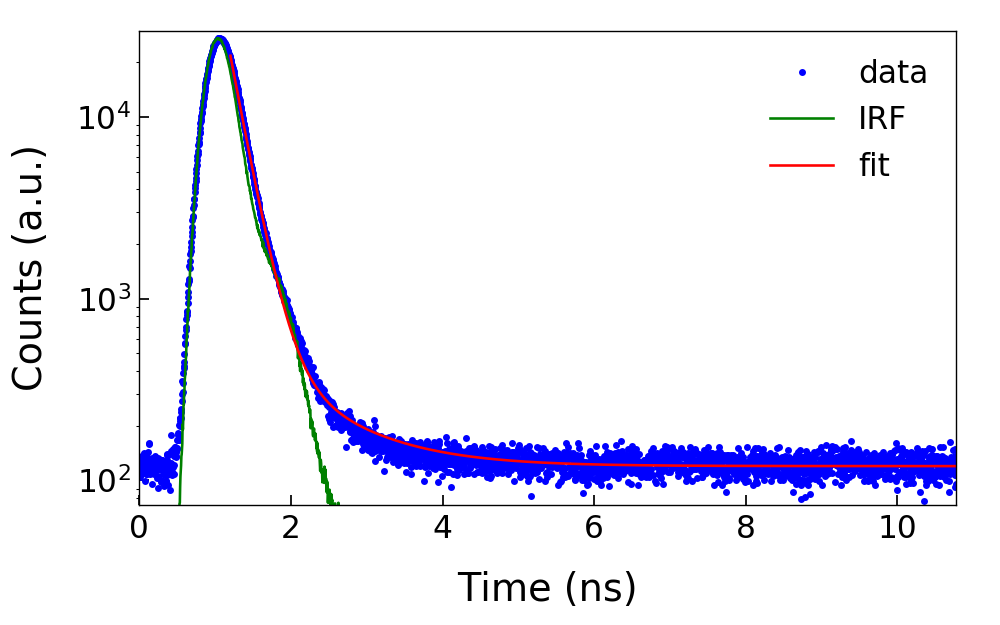

Fast rate: 5.16486630348332 ns^-1          Slow rate: 1.097168195158564 ns^-1


In [50]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

sdt_data_path = wdir + '//' + file_choice.value + '.sdt'
data = TRMData(sdt_data_path)

bckg_path = r'Z:\Projects\WSe2\2020\02 february\background_2020_02_12.sdt'
bckg = TRMData(bckg_path)

irf_path = r"Z:\Projects\WSe2\2020\02 february\IRF_mira_60kHz.sdt"
irf = TRMData(irf_path)

#remove background contribution
bckg_rate = np.mean(bckg.y) / bckg.col_t_real
data.y = data.y - bckg_rate * data.col_t_real

#rescale IRF data
irf.y = irf.y / np.max(irf.y) * np.max(data.y)

#fitting
t_laser = 1e9 / irf.laser_rep_rate
t_start = 1.2
idx = data.x>t_start
data_trunc_x = data.x[idx]
data_trunc_y = data.y[idx]
irf_trunc = irf.y[irf.y>0.1*np.max(irf.y)]

## choose fitting function
func = Decay_2_exp
## start guesses
fast_rate_guess = np.max(data.y) / np.mean(data.y)
slow_rate_guess = .05 * np.max(data.y) / np.mean(data.y)
A_fast_guess = np.max(data.y)
A_slow_guess = np.mean(data.y)
p00 = ([A_fast_guess, fast_rate_guess, A_slow_guess, slow_rate_guess, 0 , 0])
bds = ([0, 0, 0, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
# do the fit
coeffs, _ = curve_fit(func, data_trunc_x, data_trunc_y, p0=p00, bounds=bds)
y_fit = func(data_trunc_x, *coeffs)

pl = MyPlot(1, 1, xlabel='Time (ns)', ylabel='Counts (a.u.)')
pl.semilogy(data.x, data.y, 'bo', markersize=3, label='data')
pl.semilogy(irf.x, irf.y, 'g', label='IRF')
pl.semilogy(data_trunc_x, y_fit, 'r', label='fit')
pl.ax.set_ylim([0.95*np.min(data.y), 1.1*np.max(data.y)])
pl.ax.legend(prop={'size': 18}, frameon=False)

print(f"Fast rate: {coeffs[1]} ns^-1          Slow rate: {coeffs[3]} ns^-1")

In [5]:
import plotly.express as px
import plotly.graph_objs as go

In [51]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)

def go_layout():
    lay = go.Layout(title="Sine wave")
    return

def go_plot(xdata, ydata):
    data = go.Scatter(x=xdata, y=ydata)
    return {'data': [data]}

pl = go_plot(data.x, data.y)
iplot(pl)

In [52]:
import pandas as pd
df = pd.DataFrame({'Time (ns)': data.x, 'Counts (a.u.)': data.y, 'IRF': irf.y})
fig = px.scatter(df, x="Time (ns)", y="Counts (a.u.)", log_y=True,  template="plotly_dark")
iplot(fig)